# Tutorial: Covid-19
Wolfgang Kiessling

18 April 2020


## Purpose of this exercise ##
The current Corona crisis is a great opportunity to learn about two things  
 **1. Evaluate data quality and selecting the best variables**  
 **2. Model time series data for prediction**

Before we come to that let us back up a little.  
The novel Corona virus was first reported in December 2019 from the Chinese city of Wuhan.
Until the end of January 2020 the infections were largely limited to China, which responded with a complete lockdown of Wuhan and the entire Hubei Province.   
Reports of infection and death rates were constantly updated by in an intransparent way. Experts agreed that the numbers cannot be trusted, which is also supported by recent massive corrections of the death toll.  
The problem of data quality continues until the present day (April 18 2020) at global scales.  

*Discussion of what the problems might be*  
  
Problems are numerous but there may be a general tendency of underreporting infections, which leads to an overestimate of death rates. 

#### So can we make a reasonable estimate of death rates from the numbers alone? ####

To start this excercise let us see where we can access global data. Johns Hopkins University is THE global source for Coronavirus data.
https://coronavirus.jhu.edu/ 
  

The global map is copied in numerous ways by media outlets.

![screenshot](https://raw.githubusercontent.com/FAU-Analytical-Paleo/Analytical-Palaeobiology/master/01_Covid-19/img/jh-screenshot.png)

You can see the current map here: https://coronavirus.jhu.edu/map.html.
At the bottom of the page you see a link to downloadable databases, one of which is on Github.

For us the most important data are in 
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series.  
Here we focus on the global "confirmed", "deaths" and "recovered" numbers. By clicking either of these csv you see that they start from January 22 2020 and are reported on a daily basis until yesterday.

Let us first import all these data into R.

In [1]:
# reported infected 
inf <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                 header = T) 

# reported recovered
rec <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
                 header = T) 
 
# reported death
dea <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                 header=T) 


View one of these data frames and you'll see that data are arranged by country and smaller political units (in rows) and dates (in columns). Importantly numbers are cumulated. They can only increase or remain stable but never decrease. This is equivalent to diversification rates inferred from molecular clocks.

In [2]:
head(inf)

Province.State,Country.Region,Lat,Long,X1.22.20,X1.23.20,X1.24.20,X1.25.20,X1.26.20,X1.27.20,...,X4.12.20,X4.13.20,X4.14.20,X4.15.20,X4.16.20,X4.17.20,X4.18.20,X4.19.20,X4.20.20,X4.21.20
,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,1092
,Albania,41.1533,20.1683,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,609
,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,717
,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,24
,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,21,23,23,23,23,23,23,23,23,23


Let us first try to get a reasonable estimate of death rates. We get them by summing up all incidents and dividing by infection incidents.

In [3]:
x <- ncol(inf)
c.inf <- sum(inf[,x])
c.dea <- sum(dea[,x])

# Death rate
c.dea/c.inf

[1] 0.06910583

The death rate is shockingly high but perhaps unrealistic, because infection rates are not thoroughly assessed in all countries.
Let us look at a boxplot of death rates in political units with at least 2000 incidents.


[1] "Mean= 0.0477104608812318"

[1] "Median= 0.0353847540903717"

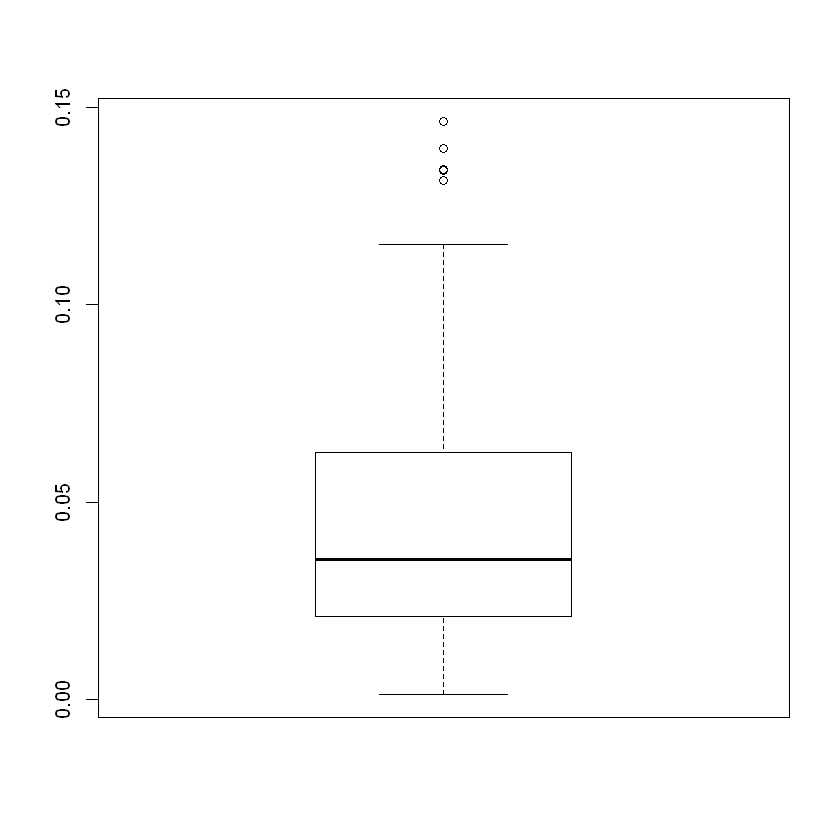

In [4]:
y <- which(inf[,x]>2000)

boxplot(dea[y,x]/inf[y,x])
paste("Mean=", mean(dea[y,x]/inf[y,x])) 
paste("Median=", median(dea[y,x]/inf[y,x])) 



You see that there is still a great heterogeneity in those data and it is hard to see a socio-economic or climatic pattern.


In [5]:
dat <- data.frame(inf$Country.Region[y], round(dea[y,x]/inf[y,x],3))
colnames(dat) <- c("Country.Region", "death.rate")

head(dat)

Country.Region,death.rate
Algeria,0.139
Argentina,0.048
Australia,0.009
Austria,0.033
Bangladesh,0.033
Belarus,0.008


### Starting the time series business ###
I focus on fatalities and global data first.
We will need two packages. Please install them using `install.packages()` if you do not have them


In [6]:
library(mgcv) # for gam models
library(forecast) # for Auto-ARIMA

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Attaching package: 'forecast'

The following object is masked from 'package:nlme':

    getResponse




You can summarize from above by:


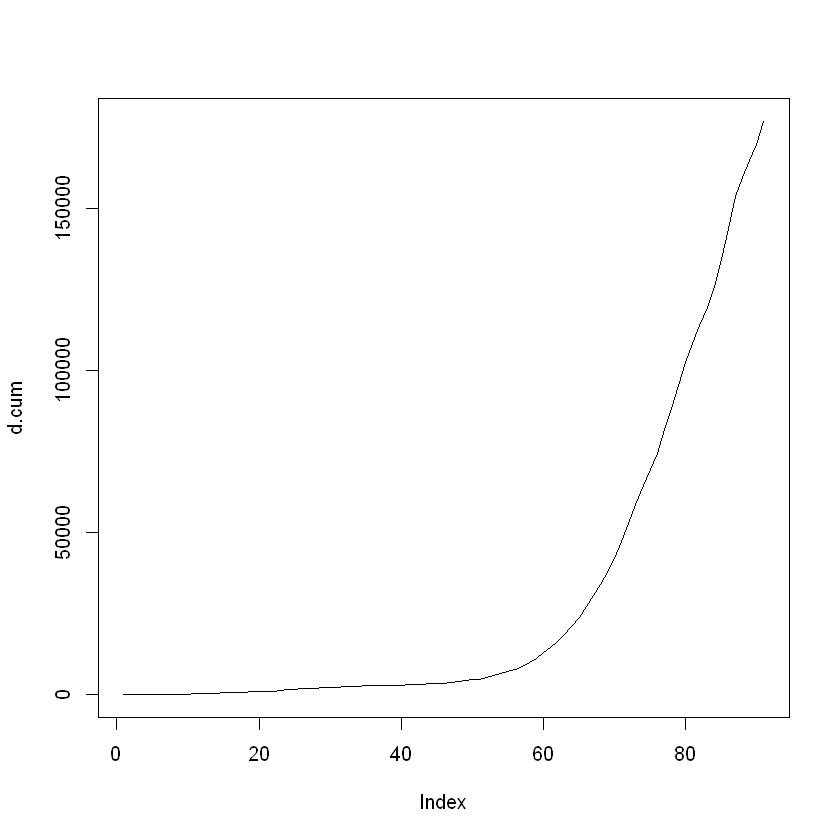

In [7]:
 dead <- dea[,-c(1:4)] # count data only
 d.cum <- apply(dead, 2, sum)
 plot(d.cum, type="l")  



We can make this nicer by creating dates and other adjustments  


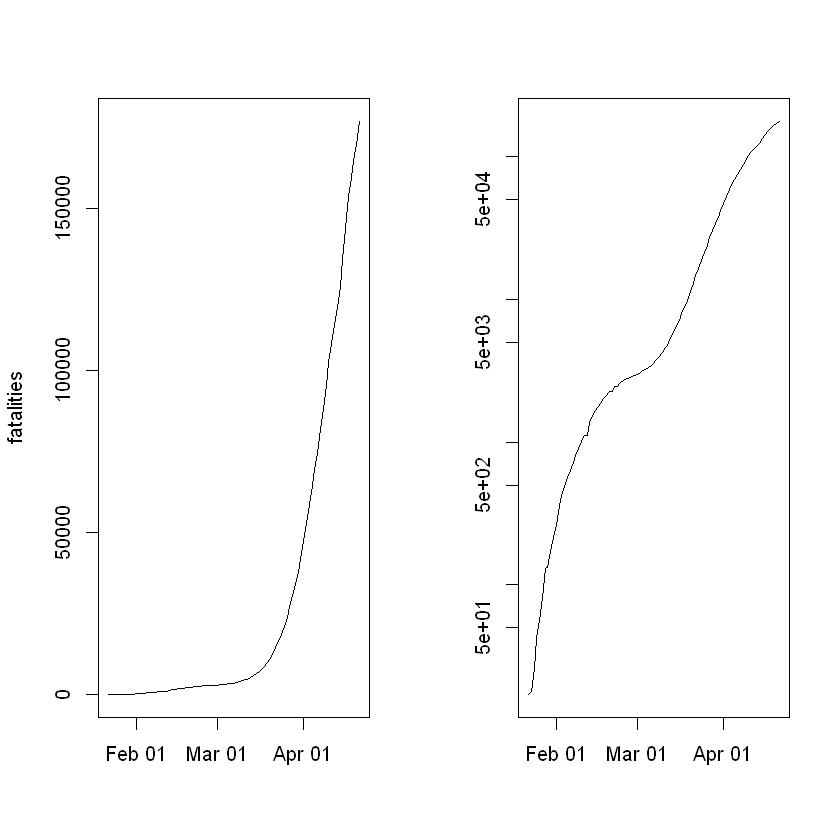

In [8]:
inds <- seq(as.Date("2020-01-22"), (Sys.Date()-1), by = "day")

#this saves the original graphic parameters and 
# update our current parameters to having two rows and one column
op <- par(mfrow=c(1,2)) 

#plotting
plot(inds,d.cum, type="l", xlab="", ylab="fatalities")  
plot(inds, d.cum, type="l", xlab="", log="y", ylab="")

#reset to orignal graphic parameters
par(op)


In the logged plot (right) you see that a simple exponential model may not be the best. The curve is more complex.
Let us now develop more complex models.
We first need to develop an index x for the regression analysis and then we list models with increasing complexity.


In [9]:
x <- c(1:ncol(dead))

# Classical model fitting
fit  <- lm(d.cum~x) # linear
fit.e <- lm(log(d.cum) ~ x)

#second degree
fit2 <- lm(d.cum~poly(x,2,raw=TRUE))

#third degree
fit3 <- lm(d.cum~poly(x,3,raw=TRUE))

#fourth degree
fit4 <- lm(d.cum~poly(x,4,raw=TRUE))

#fifth degree
fit5 <- lm(d.cum~poly(x,5,raw=TRUE))

# gam # More on this in winter
fit.g <- gam(d.cum~s(x))

Let's have a look at how the models look

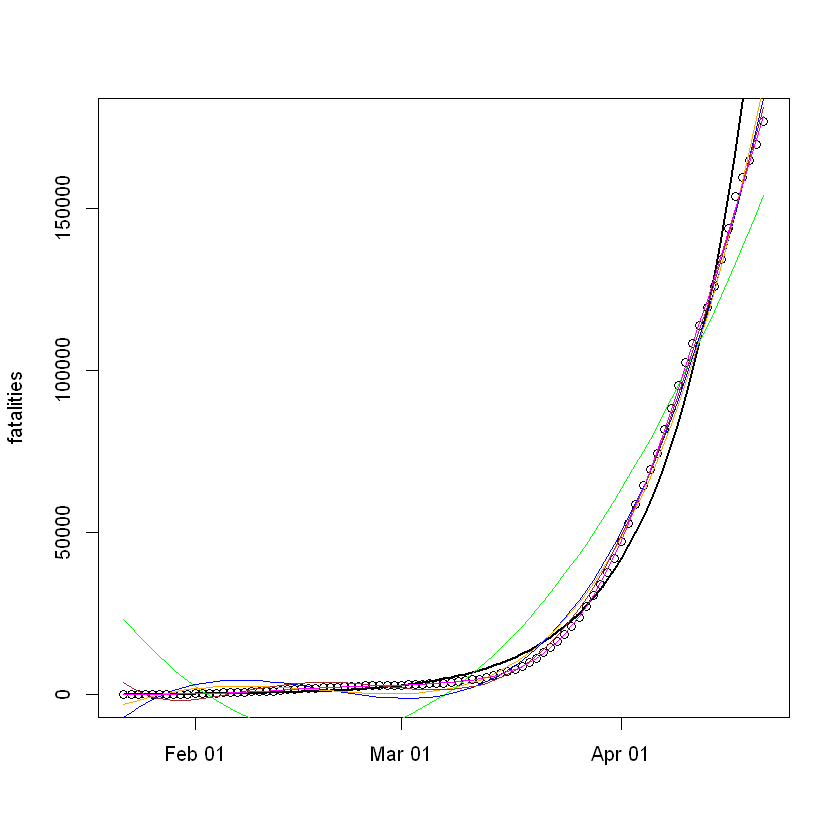

In [10]:
plot(inds,d.cum, xlab="",ylab="fatalities")

#lines(predict(fit), col="red")
lines(inds, exp(predict(fit.e)), lwd=2)
lines(inds, predict(fit2), col="green")
lines(inds, predict(fit3), col="blue")
lines(inds, predict(fit4), col="orange")
lines(inds, predict(fit5), col="brown")
lines(inds, predict(fit.g), col="magenta")

The models seem to differ only marginally, but small differences can have large effects in forecasting (see below).  
Fortunately, an exponential model seems to be outperformed by higher-order polynomials.
Among the models the GAM (general additive model) performs best in terms of AIC.


In [11]:
AIC(fit4, fit5, fit.g) # Not that the exponential model cannot be included here

,df,AIC
fit4,6.00000,1724.788
fit5,7.00000,1631.282
fit.g,10.46847,1483.534



Let us use the GAM to predict the number of fatlities by the end of April and the end of March


In [12]:
# forecast
fore <- 150
d.pre <- predict(fit.g, data.frame(x=seq(1,fore)))
inds <- seq(as.Date("2020-01-22"), as.Date("2020-01-22")+fore-1, by=1)

# data.frame(inds, d.pre)


Plotting this shows an issue



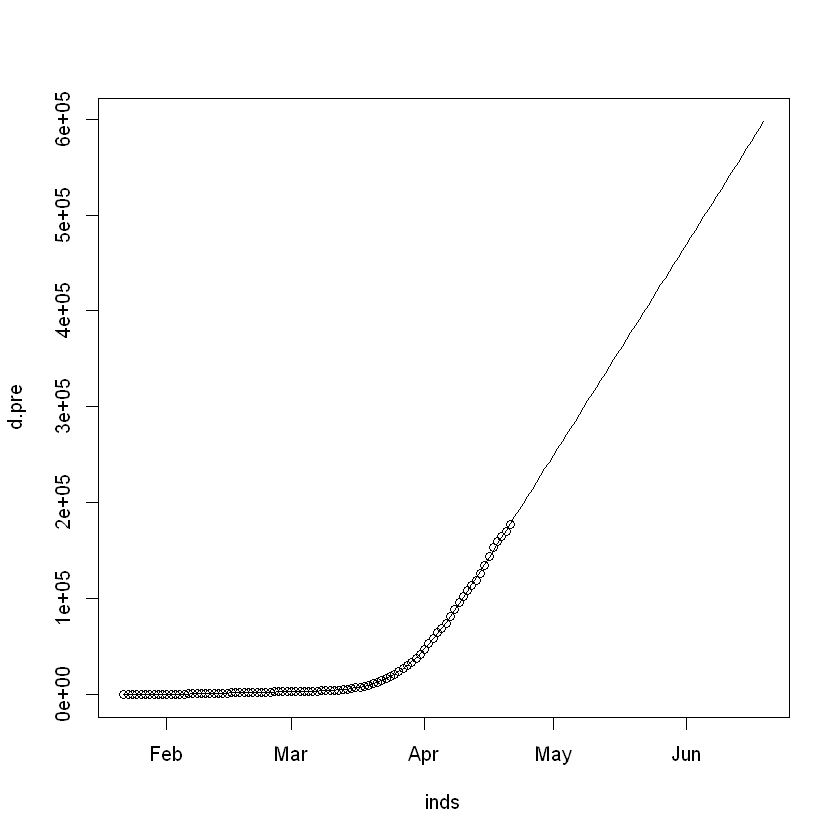

In [13]:
plot(inds, d.pre, type="l")
points(inds[1:ncol(dead)], d.cum)


The issue is that the GAM is just linearly extrapolated. 
What is the result using the fit5 model?


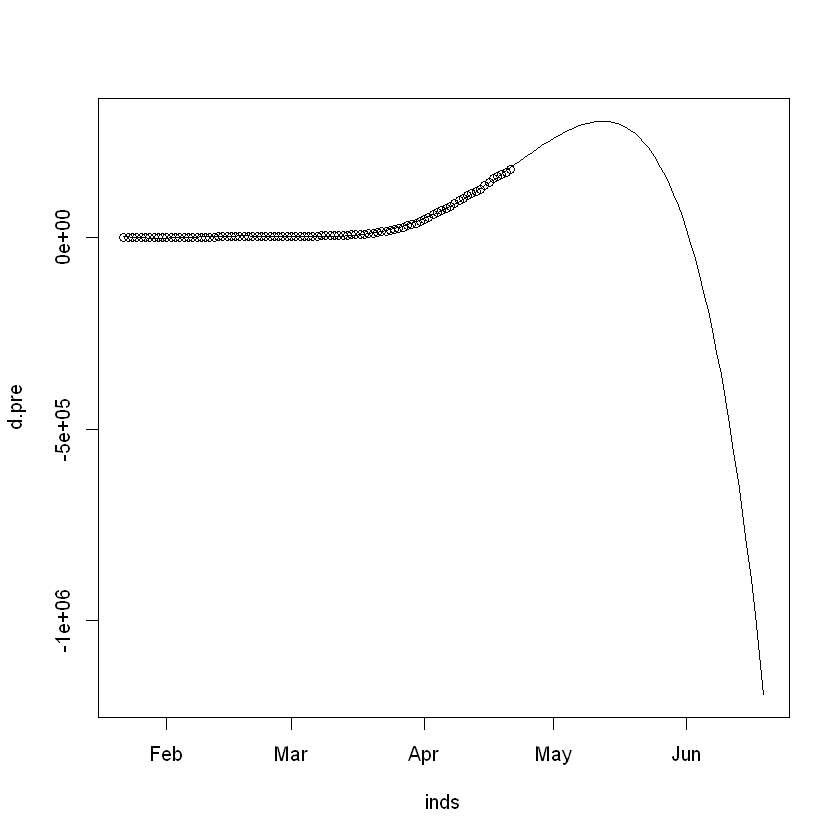

In [14]:
# forecast
d.pre <- predict(fit5, data.frame(x=seq(1,fore)))
inds <- seq(as.Date("2020-01-22"), as.Date("2020-01-22")+fore-1, by=1)
plot(inds, d.pre, type="l")
points(inds[1:ncol(dead)], d.cum)

This model predicts peak fatalities by the end of May (**when exactly?**), but cannot be right either, because the cumulative nature of the data do not allow numbers to drop.  

None of the two models shows what humankind is hoping for: a levelling off of the curve (aka logistic growth). So far our model was just informed by past data, whith no additional information whatsoever. 
This is a common situation in paleo.

# First differences
This aside, cumulative data are not suitable for statistical modeling because the are non stationary by definition. A series is said to be stationary when its mean, variance, and autocovariance are time invariant.
The solution is to use first differences, that is, the daily rate for increase in incidences.
First differences are often used in time series models, so it is good to know about them.
As before we apply polynomial models and gam to the first differences


,df,AIC
fit5,7.000000,842.7766
fit6,8.000000,844.2733
fit.g,6.351379,842.5934


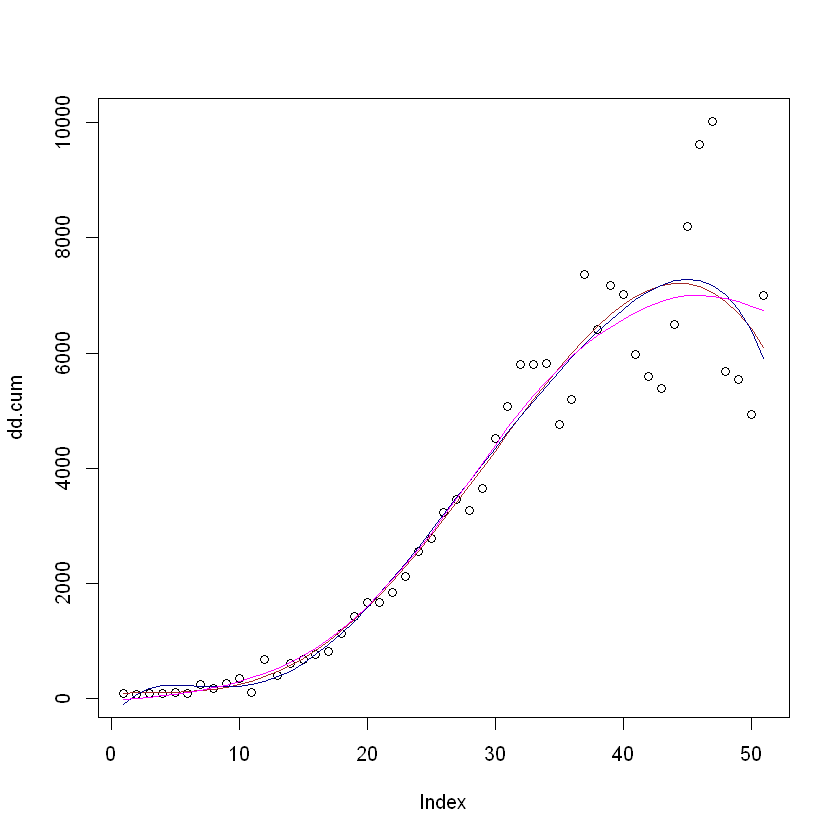

In [15]:
dd.cum <- diff(d.cum)

ind <- length(dd.cum)  
dd.cum <- dd.cum[40:ind]
    
x <- c(1:length(dd.cum))

#fifth degree
plot(dd.cum)
fit5 <- lm(dd.cum~poly(x,5,raw=TRUE))
lines(predict(fit5), col="brown")
fit6 <- lm(dd.cum~poly(x,6,raw=TRUE))
lines(predict(fit6), col="darkblue")

# gam 
fit.g <- gam(dd.cum~s(x))
lines(predict(fit.g), col="magenta")
AIC(fit5, fit6, fit.g)   


We still get the result of increasing death rates, simply because there is no evidence of a levelling off until now at global scales. Things may be different when individual countries are observed and when the timeline of observed data is manipulated. In the below, there is already a different starting date.



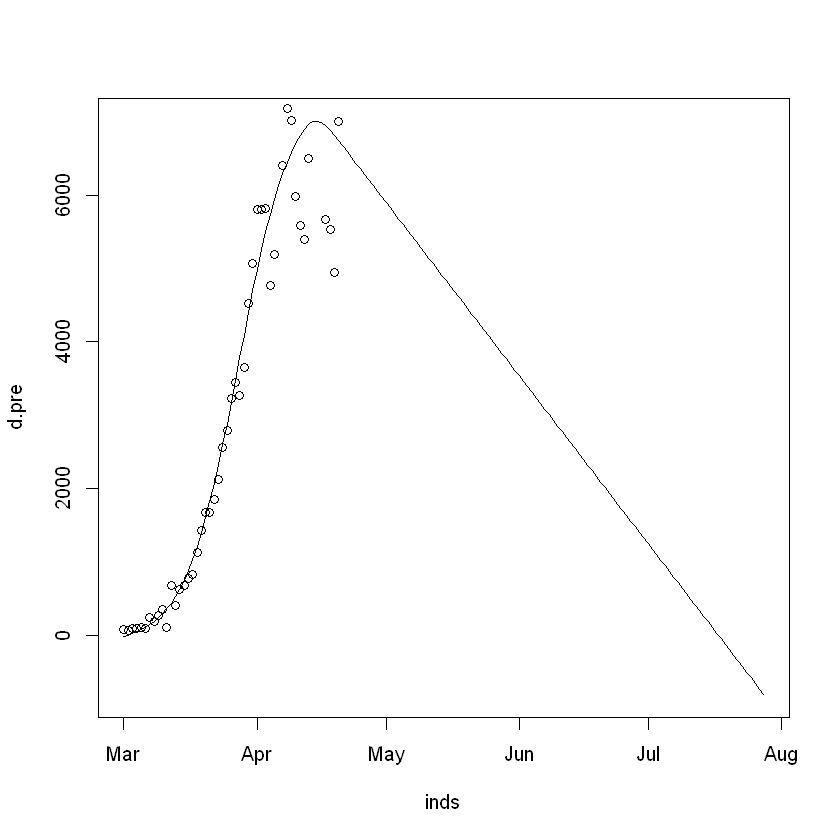

In [16]:
# forecast
fore <- 150
d.pre <- predict(fit.g, data.frame(x=seq(1,fore)))
inds <- seq(as.Date("2020-03-01"), as.Date("2020-03-01")+fore-1, by=1)

# data.frame(inds, d.pre)
plot(inds, d.pre, type="l")
points(inds[1:length(dd.cum)], dd.cum)


  
### Using Auto-Arima for forecasting ###
ARIMA stands for auto-regressive integrated moving average. We shall talk more about auto-corellation and moving averages later. For now it is enough to learn that the R package {forecast} allows for an automated arima with the optimal parameters of p,d,q.


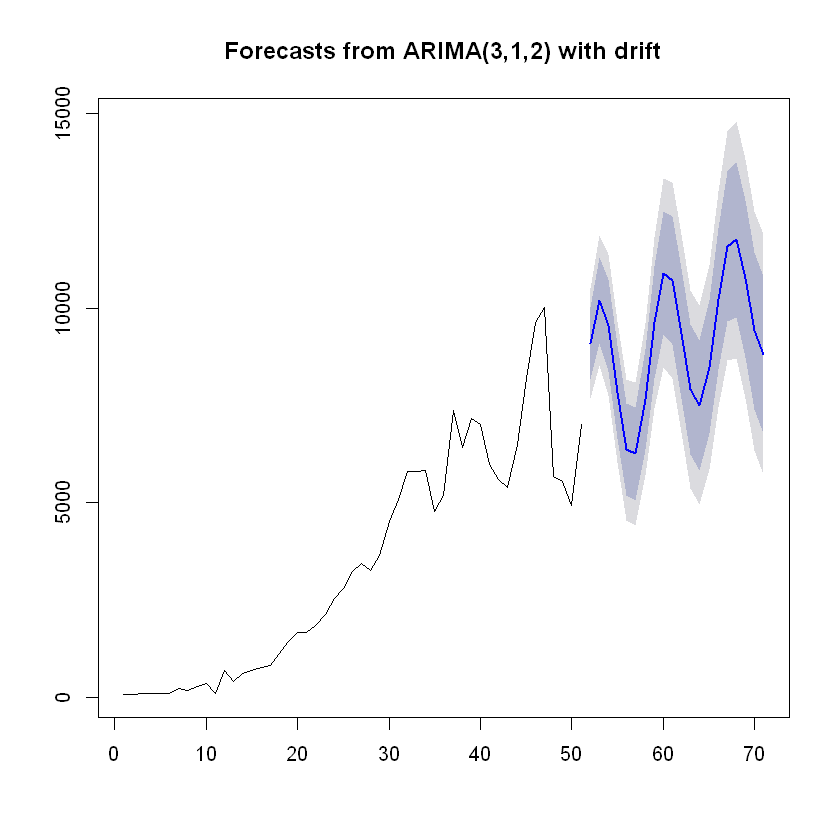

In [17]:
# forecast
fit <- auto.arima(dd.cum)
fo <- forecast(fit,h=20)
plot(fo)


  
Note that the assumption of stationarity is violated here, so arima forecasting should not be applied to these data. 

#### Classwork/Homework: Focus on individual countries ####
We may achieve better predictive performance with national data, especially when data are deemed good.
In addition better predictions we may also learn about lags in the time series, another important concept of time series analysis.
To  get national data from the raw files, use the aggregate() function


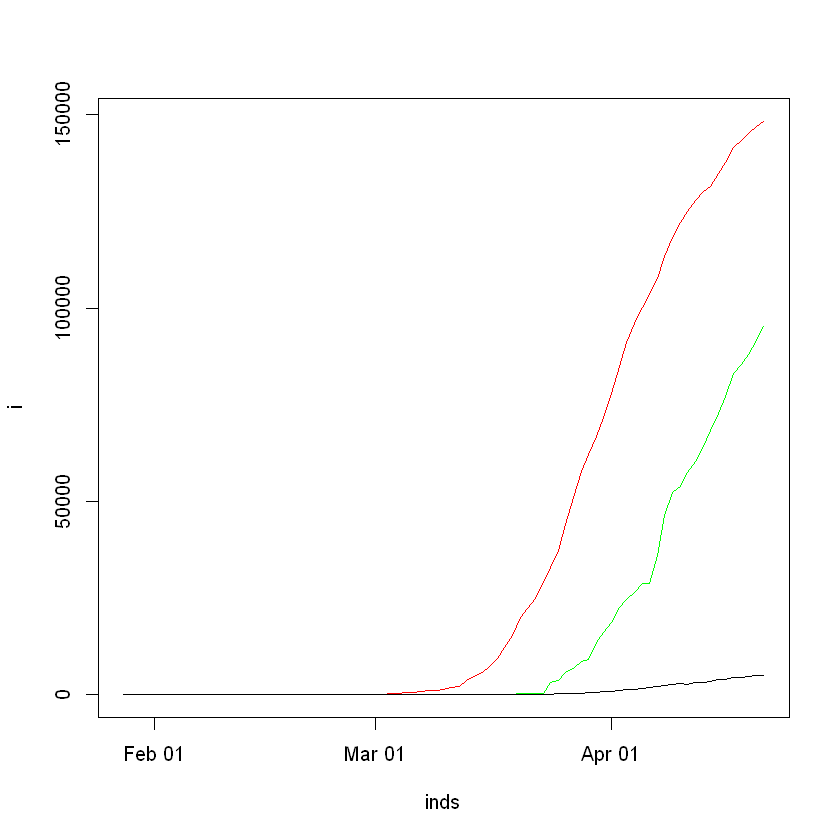

In [18]:
infe <- inf[,-c(1:4)]
dead <- dea[,-c(1:4)]
reco <- rec[,-c(1:4)]
i.country <- aggregate(infe, by=list(inf$Country.Region), FUN=sum)
r.country <- aggregate(reco, by=list(rec$Country.Region), FUN=sum)
d.country <- aggregate(dead, by=list(dea$Country.Region), FUN=sum)
i <- i.country[66,-1] # Germany
r <- r.country[66,-1]
d <- d.country[66,-1]
  
# which(d.country$Group.1=="Germany")
    
i <- as.numeric(i.country[66,-1])
r <- as.numeric(r.country[66,-1])
d <- as.numeric(d.country[66,-1])
inds <- seq(as.Date("2020-01-22"), (Sys.Date()-1), by = "day")

# When first infection reported?
st <- which(i>0)[1]
inds <- inds[-(1:st)]
i <- i[-(1:st)]
r <- r[-(1:st)]
d <- d[-(1:st)]

plot(inds, i, col="red", type="l")
lines(inds, r, col="green")
lines(inds, d)

  
  Now we go on with first differences and gam smoothing for all three variables.
  


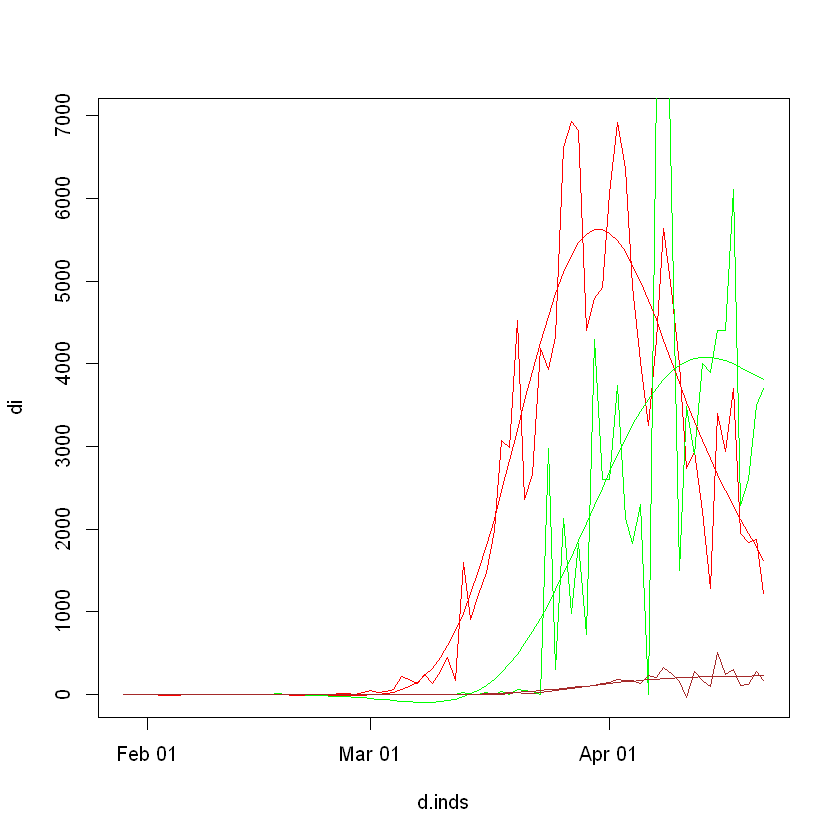

In [19]:
# First differences and gam smoothing
di <- diff(i)
dr <- diff(r)
dd <- diff(d)
   
d.inds <- inds[-1]
plot(d.inds, di, col="red", type="l")
lines(d.inds, dr, col="green")
lines(d.inds, dd, col="brown")

x <- c(1:length(d.inds))
fit.gi <- gam(di~s(x))
fit.gr <- gam(dr~s(x))
fit.gd <- gam(dd~s(x))
lines(d.inds, predict(fit.gi), col="red")
lines(d.inds, predict(fit.gr), col="green")
lines(d.inds, predict(fit.gd), col="brown")

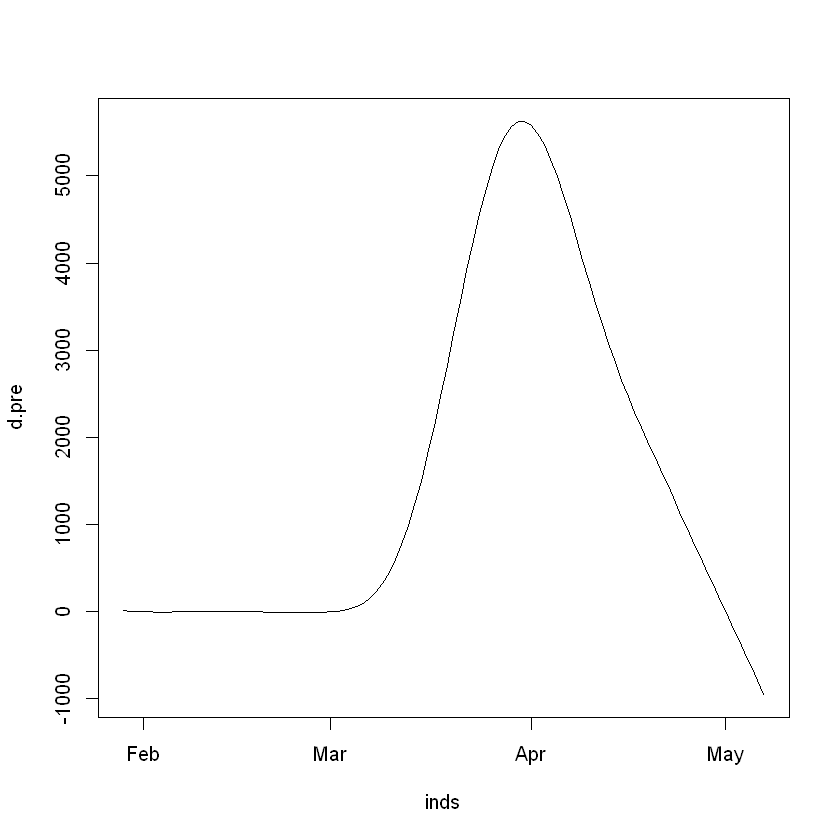

In [20]:
# forecast for infection rates (classical gam extrapolation)
fore <- 100
d.pre <- predict(fit.gi, data.frame(x=seq(1,fore)), link="log", type="response")
inds <- seq(as.Date(d.inds[1]), as.Date(d.inds[1])+fore-1, by=1)

plot(inds, d.pre, type="l")

  
We still have the problem of predicted negative infection rates. 
    


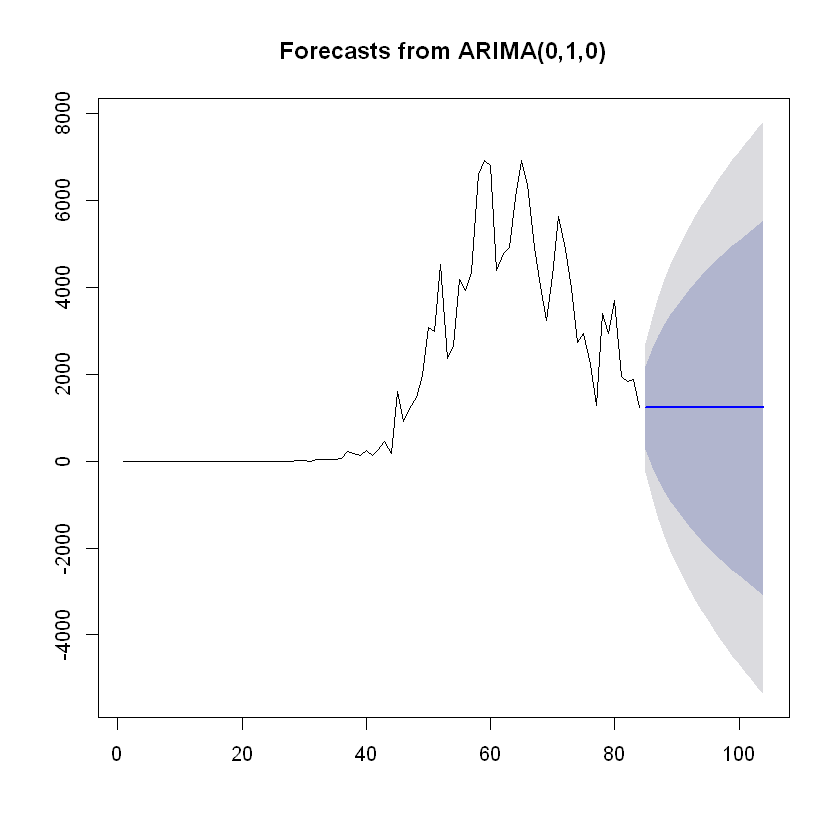

In [21]:
# forecast for infection rates (Arima)
fit <- auto.arima(di)
fo <- forecast(fit,h=20)
plot(fo)


#### Homework: How sensitive are predictions to the number of known data points ####

We now have a history of 90 days to inform our model. 
How does forecast change when limiting the time of previous observations?  
 **- Limit data start to when Covi-19 became a global pandemic (March 1)**  
 **- Limit data end to some arbitrary date in the first two weeks of April**
